<a href="https://colab.research.google.com/github/m-u-d-i-t/CG/blob/main/CG_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install random
!pip install math
!pip install time
!pip install collections
!pip install tqdm
!pip install pandas
!pip install matplotlib.colors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 12.0 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math
ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import time
from collections import defaultdict, deque
from tqdm.notebook import tqdm
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from gymnasium.wrappers import TimeLimit

In [ ]:
# Set the style for our plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Make sure the random seed is fixed for reproducibility
np.random.seed(42)
random.seed(42)

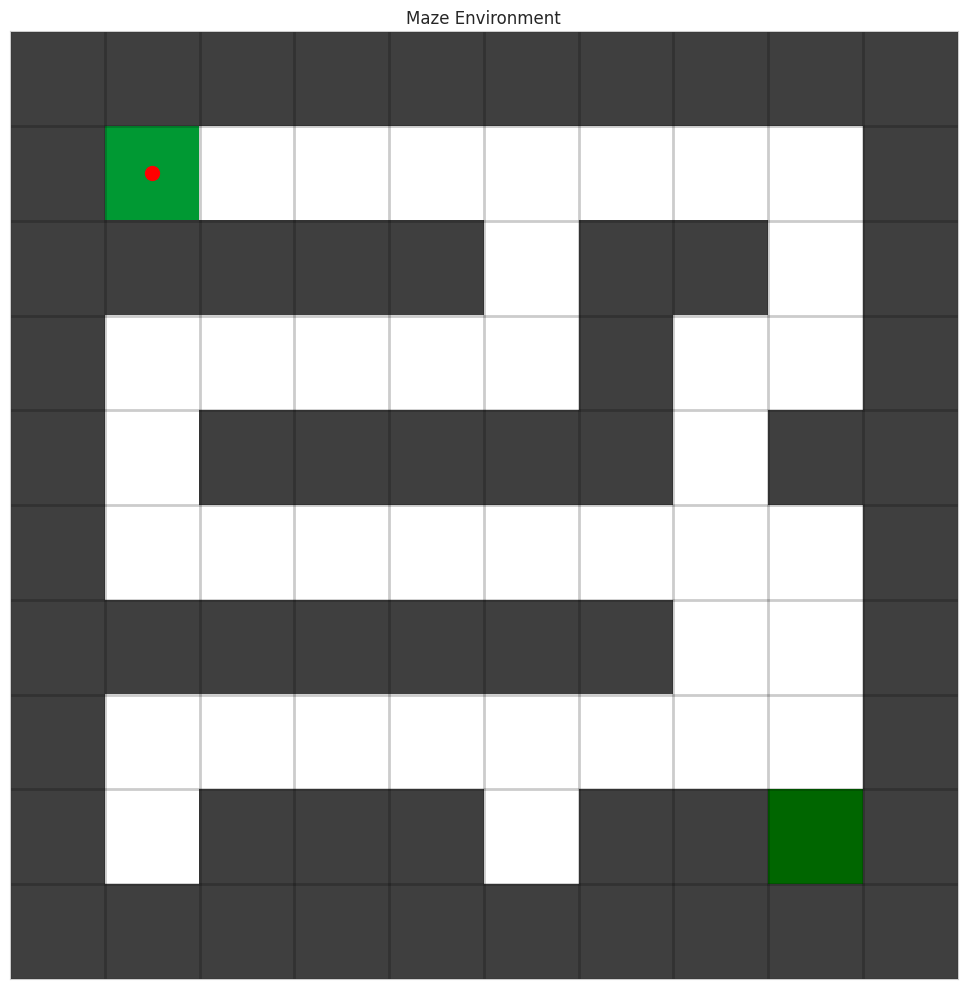

In [ ]:
# 1. Create a Simple Maze Environment
# ===================================

class MazeEnv(gym.Env):
    """
    A customized maze environment that follows the gym interface.
    The maze is represented as a grid where:
    - 0: Empty space (can move)
    - 1: Wall (cannot move)
    - 2: Goal (end of episode)
    - 3: Starting position
    """
    metadata = {'render_modes': ['human', 'rgb_array']}

    def __init__(self, maze=None, render_mode=None):
        super(MazeEnv, self).__init__()

        # Define default maze if none provided
        if maze is None:
            # 0: empty, 1: wall, 2: goal, 3: start
            self.maze = np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 3, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 1, 1, 0, 1, 1, 2, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
            ])
        else:
            self.maze = maze

        # Find start position
        start_pos = np.where(self.maze == 3)
        self.start_pos = (start_pos[0][0], start_pos[1][0])
        self.current_pos = self.start_pos

        # Define action and observation spaces
        self.action_space = gym.spaces.Discrete(4)  # Up, Right, Down, Left
        self.observation_space = gym.spaces.Box(
            low=0, high=3, shape=(self.maze.shape[0], self.maze.shape[1]), dtype=np.uint8
        )

        self.steps = 0
        self.max_steps = 100
        self.render_mode = render_mode

    def reset(self, seed=None, options=None):
        if seed is not None:
            super().reset(seed=seed)
        self.current_pos = self.start_pos
        self.steps = 0
        observation = self._get_observation()
        info = {}  # Additional info if needed
        return observation, info

    def step(self, action):
        self.steps += 1
        row, col = self.current_pos
        new_row, new_col = row, col

        # Execute action (0: Up, 1: Right, 2: Down, 3: Left)
        if action == 0:  # Up
            new_row = max(0, row - 1)
        elif action == 1:  # Right
            new_col = min(self.maze.shape[1] - 1, col + 1)
        elif action == 2:  # Down
            new_row = min(self.maze.shape[0] - 1, row + 1)
        elif action == 3:  # Left
            new_col = max(0, col - 1)

        # Check if new position is valid
        if self.maze[new_row, new_col] != 1:  # Not a wall
            self.current_pos = (new_row, new_col)

        # Get new observation
        observation = self._get_observation()

        # Check if goal reached
        done = False
        if self.maze[self.current_pos] == 2:  # Goal
            done = True
            reward = 10.0
        else:
            reward = -0.1  # Small penalty for each step to encourage shortest path

        # Check for timeout
        truncated = self.steps >= self.max_steps

        # Return formatted step results
        info = {}  # Additional info if needed
        return observation, reward, done, truncated, info

    def _get_observation(self):
        # Create a copy of the maze as our observation
        obs = self.maze.copy()

        # Mark current position if not at goal or start
        if self.maze[self.current_pos] not in [2, 3]:
            # Temporarily mark current position for observation
            r, c = self.current_pos
            obs[r, c] = 4  # Use 4 to represent current position in observation

        return obs

    def render(self):
        if self.render_mode == 'human':
            # Simple ASCII rendering for console
            for i in range(self.maze.shape[0]):
                for j in range(self.maze.shape[1]):
                    if (i, j) == self.current_pos:
                        print('P', end=' ')
                    elif self.maze[i, j] == 0:
                        print('.', end=' ')
                    elif self.maze[i, j] == 1:
                        print('#', end=' ')
                    elif self.maze[i, j] == 2:
                        print('G', end=' ')
                    elif self.maze[i, j] == 3:
                        print('S', end=' ')
                print()
            print()
        elif self.render_mode == 'rgb_array':
            # Return an RGB representation of the environment
            grid = np.zeros((self.maze.shape[0], self.maze.shape[1], 3), dtype=np.uint8)

            # Define colors for different elements
            empty_color = np.array([255, 255, 255])  # White
            wall_color = np.array([0, 0, 0])  # Black
            goal_color = np.array([0, 255, 0])  # Green
            start_color = np.array([0, 0, 255])  # Blue
            agent_color = np.array([255, 0, 0])  # Red

            # Fill grid with colors based on maze
            for i in range(self.maze.shape[0]):
                for j in range(self.maze.shape[1]):
                    if self.maze[i, j] == 0:  # Empty
                        grid[i, j] = empty_color
                    elif self.maze[i, j] == 1:  # Wall
                        grid[i, j] = wall_color
                    elif self.maze[i, j] == 2:  # Goal
                        grid[i, j] = goal_color
                    elif self.maze[i, j] == 3:  # Start
                        grid[i, j] = start_color

            # Add agent to the grid
            r, c = self.current_pos
            grid[r, c] = agent_color

            return grid
        else:
            return None

    def visualize(self, path=None):
        """Visualize the maze with matplotlib"""
        fig, ax = plt.subplots(figsize=(10, 10))

        # Create a custom colormap
        colors = [(1, 1, 1), (0, 0, 0), (0, 0.8, 0), (0, 0, 0.8)]  # white, black, green, blue
        cmap = LinearSegmentedColormap.from_list('maze_cmap', colors, N=5)

        # Plot the maze
        ax.imshow(self.maze, cmap=cmap, vmin=0, vmax=4)

        # Plot the current position
        r, c = self.current_pos
        ax.plot(c, r, 'ro', markersize=10)

        # Plot path if provided
        if path:
            path_r, path_c = zip(*path)
            ax.plot(path_c, path_r, 'r-', linewidth=2, alpha=0.7)

        # Set grid lines
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2, alpha=0.2)
        ax.set_xticks(np.arange(-0.5, self.maze.shape[1], 1))
        ax.set_yticks(np.arange(-0.5, self.maze.shape[0], 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Make the grid lines appear behind the maze elements
        ax.set_axisbelow(True)

        plt.title("Maze Environment")
        plt.tight_layout()
        plt.show()

# Let's create and visualize our maze environment
env = MazeEnv()
env.reset()
env.visualize()


In [ ]:
# 2. Monte Carlo Tree Search (MCTS) Implementation
# ===============================================

class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.value = 0.0
        self.untried_actions = list(range(4))  # All possible actions initially
        random.shuffle(self.untried_actions)  # Randomize action selection

    def is_fully_expanded(self):
        return len(self.untried_actions) == 0

    def is_terminal(self):
        r, c = self.state
        return env.maze[r, c] == 2  # Check if goal reached

    def best_child(self, exploration_weight=1.0):
        """UCB1 formula to select best child: value/visits + exploration_weight * sqrt(2 * ln(parent_visits) / visits)"""
        if not self.children:
            return None

        def score(node):
            exploitation = node.value / node.visits if node.visits > 0 else 0
            exploration = exploration_weight * math.sqrt(2 * math.log(self.visits) / node.visits) if node.visits > 0 else float('inf')
            return exploitation + exploration

        return max(self.children.values(), key=score)

    def expand(self, action, state):
        """Add a new child node"""
        child = MCTSNode(state, parent=self, action=action)
        self.untried_actions.remove(action)
        self.children[action] = child
        return child

class MCTS:
    def __init__(self, env, exploration_weight=1.0, simulation_depth=100):
        self.env = env
        self.exploration_weight = exploration_weight
        self.simulation_depth = simulation_depth
        self.q_values = {}  # Dictionary to store Q-values for visualization

    def search(self, initial_state, iterations=1000):
        """Run MCTS for a given number of iterations"""
        root = MCTSNode(initial_state)

        for _ in range(iterations):
            # Selection and expansion
            node = self.select_and_expand(root)

            # Simulation
            reward = self.simulate(node.state)

            # Backpropagation
            self.backpropagate(node, reward)

            # Store Q-values for visualization
            for action, child in root.children.items():
                if child.visits > 0:
                    self.q_values[(root.state, action)] = child.value / child.visits

        # Return the best action
        best_child = root.best_child(exploration_weight=0)
        return best_child.action if best_child else random.choice(range(4))

    def select_and_expand(self, node):
        """Select a node to expand using UCB1"""
        while not node.is_terminal():
            if not node.is_fully_expanded():
                # Expand a random untried action
                action = node.untried_actions[0]
                next_state = self.get_next_state(node.state, action)
                return node.expand(action, next_state)
            else:
                # Select best child according to UCB
                node = node.best_child(self.exploration_weight)
                if node is None:  # All children lead to invalid states
                    return node.parent
        return node

    def simulate(self, state, depth=None):
        """Run a random simulation from the current state"""
        if depth is None:
            depth = self.simulation_depth

        current_state = state
        cumulative_reward = 0
        discount_factor = 0.99

        for i in range(depth):
            # Check if terminal state
            r, c = current_state
            if self.env.maze[r, c] == 2:  # Goal
                cumulative_reward += 10.0  # Terminal reward
                break

            # Try random action
            valid_action = False
            attempts = 0
            while not valid_action and attempts < 10:
                action = random.randint(0, 3)
                next_state = self.get_next_state(current_state, action)
                if next_state != current_state:  # Valid move
                    valid_action = True
                attempts += 1

            if valid_action:
                current_state = next_state
                cumulative_reward += -0.1 * (discount_factor ** i)  # Small step penalty
            else:
                # All directions are walls
                break

        return cumulative_reward

    def backpropagate(self, node, reward):
        """Update the statistics of nodes from the leaf to the root"""
        while node is not None:
            node.visits += 1
            node.value += reward
            node = node.parent

    def get_next_state(self, state, action):
        """Get the next state after taking an action"""
        row, col = state
        next_row, next_col = row, col

        # Execute action (0: Up, 1: Right, 2: Down, 3: Left)
        if action == 0:  # Up
            next_row = max(0, row - 1)
        elif action == 1:  # Right
            next_col = min(self.env.maze.shape[1] - 1, col + 1)
        elif action == 2:  # Down
            next_row = min(self.env.maze.shape[0] - 1, row + 1)
        elif action == 3:  # Left
            next_col = max(0, col - 1)

        # Check if new position is valid
        if self.env.maze[next_row, next_col] != 1:  # Not a wall
            return (next_row, next_col)
        else:
            return state  # Stay in place if hitting a wall

In [ ]:
# 3. Q-Learning Implementation
# ===========================

class QLearning:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay=0.995):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay = exploration_decay

        # Initialize Q-table with zeros
        self.q_table = {}
        self.q_values_history = {}  # To track Q-values over time

    def get_q_value(self, state, action):
        """Get Q-value for a state-action pair"""
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if random.random() < self.exploration_rate:
            # Explore: choose a random action
            return random.randint(0, 3)
        else:
            # Exploit: choose the best action based on Q-values
            q_values = [self.get_q_value(state, a) for a in range(4)]
            return np.argmax(q_values)

    def update_q_value(self, state, action, next_state, reward, done):
        """Update Q-value using the Q-learning update rule"""
        current_q = self.get_q_value(state, action)

        # If terminal state, there's no future reward
        if done:
            max_future_q = 0
        else:
            max_future_q = max([self.get_q_value(next_state, a) for a in range(4)])

        # Q-learning update rule
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_future_q - current_q)
        self.q_table[(state, action)] = new_q

        # Track Q-values over time
        key = (state, action)
        if key not in self.q_values_history:
            self.q_values_history[key] = []
        self.q_values_history[key].append(new_q)

    def decay_exploration(self):
        """Decay exploration rate"""
        self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

    def train(self, episodes=1000):
        """Train the Q-learning agent"""
        rewards_per_episode = []
        steps_per_episode = []

        for episode in tqdm(range(episodes), desc="Training Q-Learning"):
            state, _ = self.env.reset()
            state = tuple(map(tuple, np.where(state == 4 if 4 in state else state == 3)))
            state = (state[0][0], state[1][0])  # Convert to (row, col) format

            done = False
            truncated = False
            episode_reward = 0
            steps = 0

            while not (done or truncated):
                action = self.choose_action(state)
                next_state_full, reward, done, truncated, _ = self.env.step(action)

                # Extract agent position from the next state
                next_state = tuple(map(tuple, np.where(next_state_full == 4 if 4 in next_state_full else next_state_full == 3)))
                next_state = (next_state[0][0], next_state[1][0])  # Convert to (row, col) format

                self.update_q_value(state, action, next_state, reward, done)
                state = next_state
                episode_reward += reward
                steps += 1

            rewards_per_episode.append(episode_reward)
            steps_per_episode.append(steps)
            self.decay_exploration()

        return rewards_per_episode, steps_per_episode

    def get_policy(self):
        """Extract the learned policy from Q-table"""
        policy = {}
        for (state, action), value in self.q_table.items():
            if state not in policy or value > self.q_table[(state, policy[state])]:
                policy[state] = action
        return policy

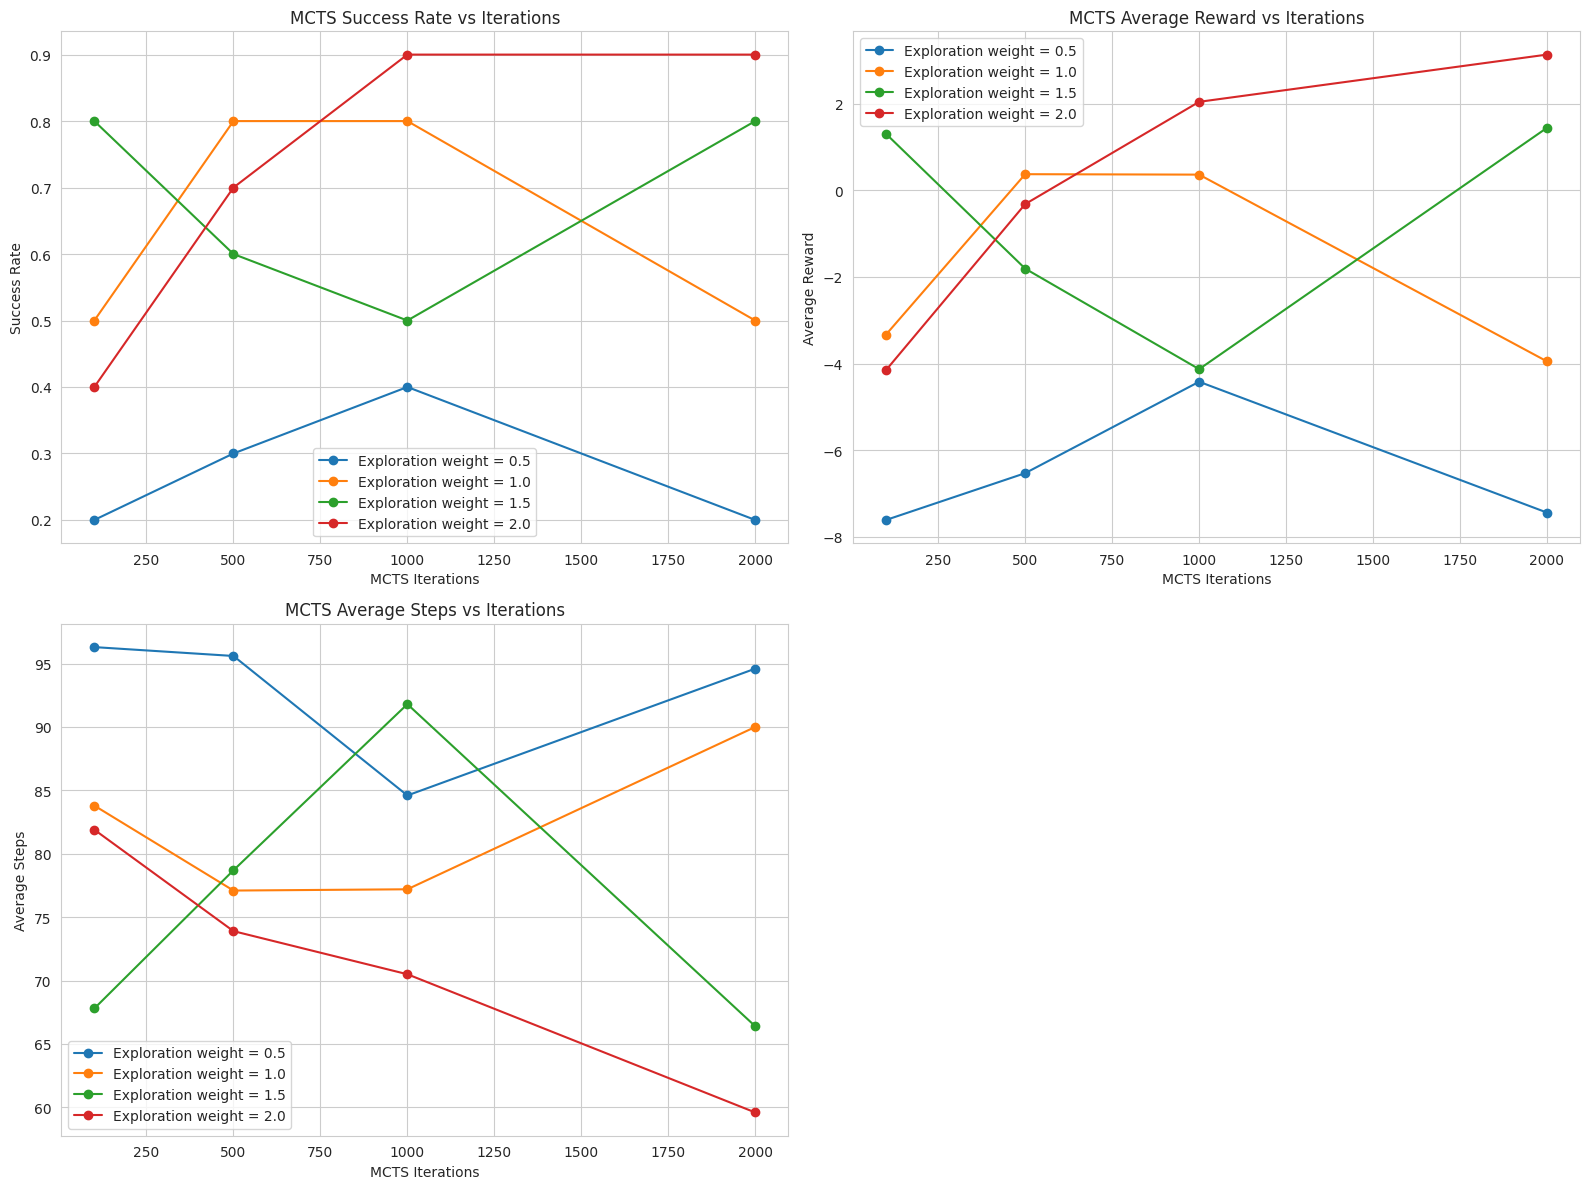

In [ ]:
# 4. Compare MCTS and Q-Learning
# ============================

# First, let's evaluate different MCTS parameters
def evaluate_mcts_parameters():
    env = MazeEnv()

    # Parameters to test
    exploration_weights = [0.5, 1.0, 1.5, 2.0]
    iterations_list = [100, 500, 1000, 2000]

    results = []

    for exploration_weight in exploration_weights:
        for iterations in iterations_list:
            # Run 10 episodes for each parameter combination
            success_count = 0
            total_rewards = 0
            total_steps = 0

            for _ in range(10):
                mcts = MCTS(env, exploration_weight=exploration_weight)
                state, _ = env.reset()

                # Extract agent position from state
                agent_pos = tuple(map(tuple, np.where(state == 4 if 4 in state else state == 3)))
                agent_pos = (agent_pos[0][0], agent_pos[1][0])

                done = False
                truncated = False
                episode_reward = 0
                steps = 0
                path = [agent_pos]

                while not (done or truncated):
                    action = mcts.search(agent_pos, iterations=iterations)
                    state, reward, done, truncated, _ = env.step(action)

                    # Extract agent position from next state
                    agent_pos = tuple(map(tuple, np.where(state == 4 if 4 in state else state == 3)))
                    agent_pos = (agent_pos[0][0], agent_pos[1][0])

                    path.append(agent_pos)
                    episode_reward += reward
                    steps += 1

                    if steps >= 100:  # Prevent infinite loops
                        truncated = True

                if done:  # Successfully reached the goal
                    success_count += 1

                total_rewards += episode_reward
                total_steps += steps

            # Record results
            results.append({
                'exploration_weight': exploration_weight,
                'iterations': iterations,
                'success_rate': success_count / 10,
                'avg_reward': total_rewards / 10,
                'avg_steps': total_steps / 10
            })

    return pd.DataFrame(results)

mcts_results = evaluate_mcts_parameters()

# Visualize MCTS parameter results
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
for ew in mcts_results['exploration_weight'].unique():
    data = mcts_results[mcts_results['exploration_weight'] == ew]
    plt.plot(data['iterations'], data['success_rate'], 'o-', label=f'Exploration weight = {ew}')
plt.xlabel('MCTS Iterations')
plt.ylabel('Success Rate')
plt.title('MCTS Success Rate vs Iterations')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for ew in mcts_results['exploration_weight'].unique():
    data = mcts_results[mcts_results['exploration_weight'] == ew]
    plt.plot(data['iterations'], data['avg_reward'], 'o-', label=f'Exploration weight = {ew}')
plt.xlabel('MCTS Iterations')
plt.ylabel('Average Reward')
plt.title('MCTS Average Reward vs Iterations')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for ew in mcts_results['exploration_weight'].unique():
    data = mcts_results[mcts_results['exploration_weight'] == ew]
    plt.plot(data['iterations'], data['avg_steps'], 'o-', label=f'Exploration weight = {ew}')
plt.xlabel('MCTS Iterations')
plt.ylabel('Average Steps')
plt.title('MCTS Average Steps vs Iterations')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mcts_parameter_results.png')
plt.show()

Training Q-Learning:   0%|          | 0/1000 [00:00<?, ?it/s]

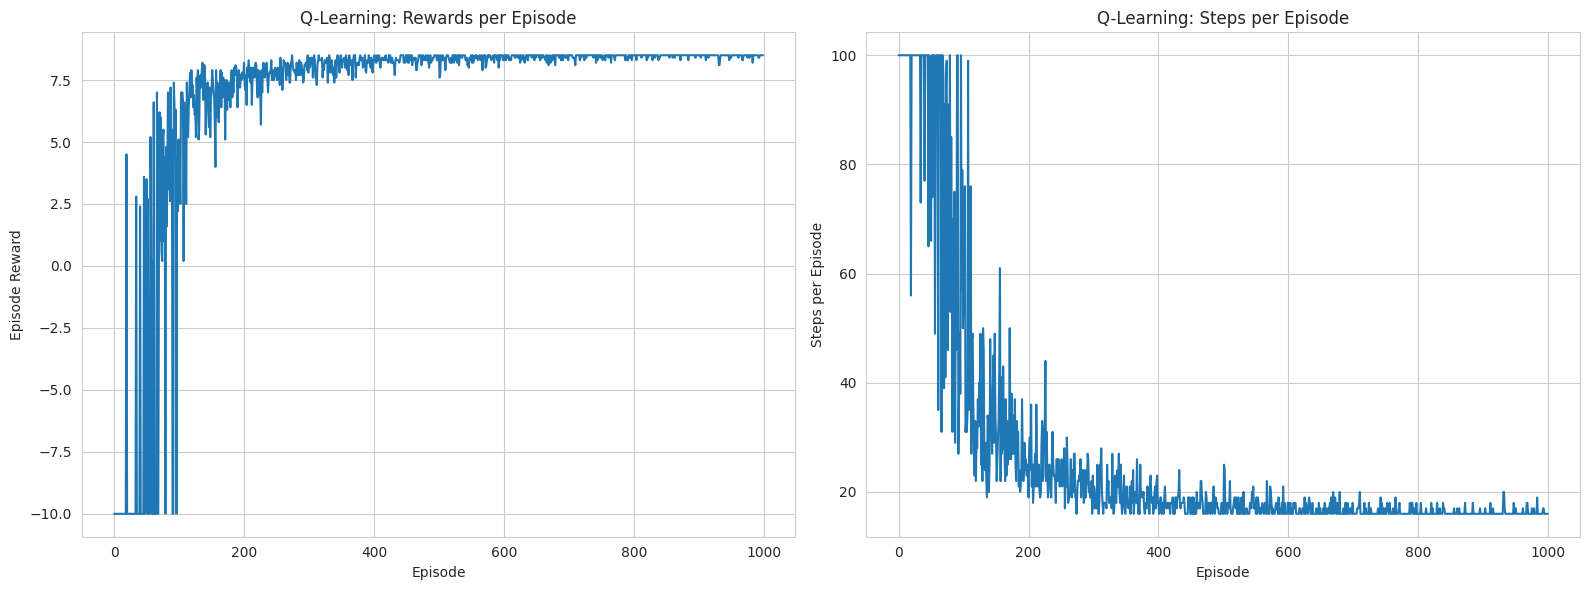

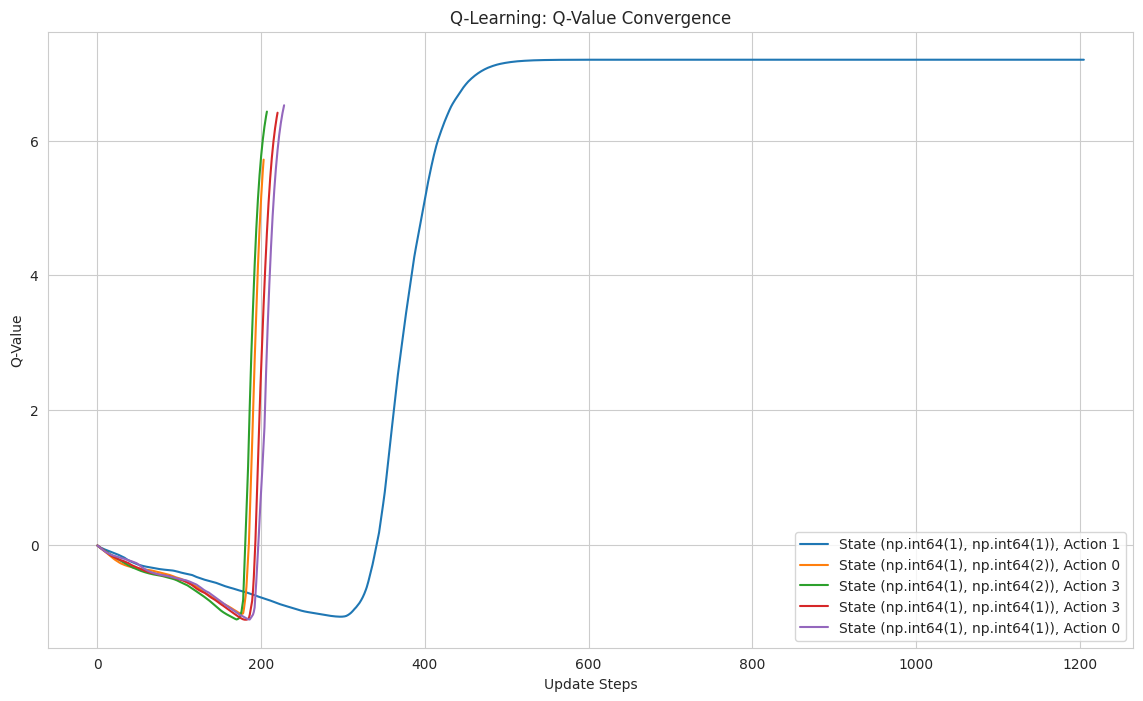

In [ ]:
# Now, train and evaluate Q-Learning
env = MazeEnv()
q_agent = QLearning(env, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0)
rewards_history, steps_history = q_agent.train(episodes=1000)

# Plot Q-Learning training progress
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('Q-Learning: Rewards per Episode')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(steps_history)
plt.xlabel('Episode')
plt.ylabel('Steps per Episode')
plt.title('Q-Learning: Steps per Episode')
plt.grid(True)

plt.tight_layout()
plt.savefig('q_learning_training.png')
plt.show()

# Visualize Q-value convergence for selected state-action pairs
plt.figure(figsize=(14, 8))

# Select a few interesting state-action pairs
key_states = list(q_agent.q_values_history.keys())[:5]  # Take first 5 state-action pairs

for i, key in enumerate(key_states):
    state, action = key
    values = q_agent.q_values_history[key]
    plt.plot(values, label=f'State {state}, Action {action}')

plt.xlabel('Update Steps')
plt.ylabel('Q-Value')
plt.title('Q-Learning: Q-Value Convergence')
plt.legend()
plt.grid(True)
plt.savefig('q_value_convergence.png')
plt.show()


MCTS Evaluation:
Success Rate: 0.62
Average Reward: -1.66
Average Steps: 79.20

Q-Learning Evaluation:
Success Rate: 1.00
Average Reward: 8.50
Average Steps: 16.00


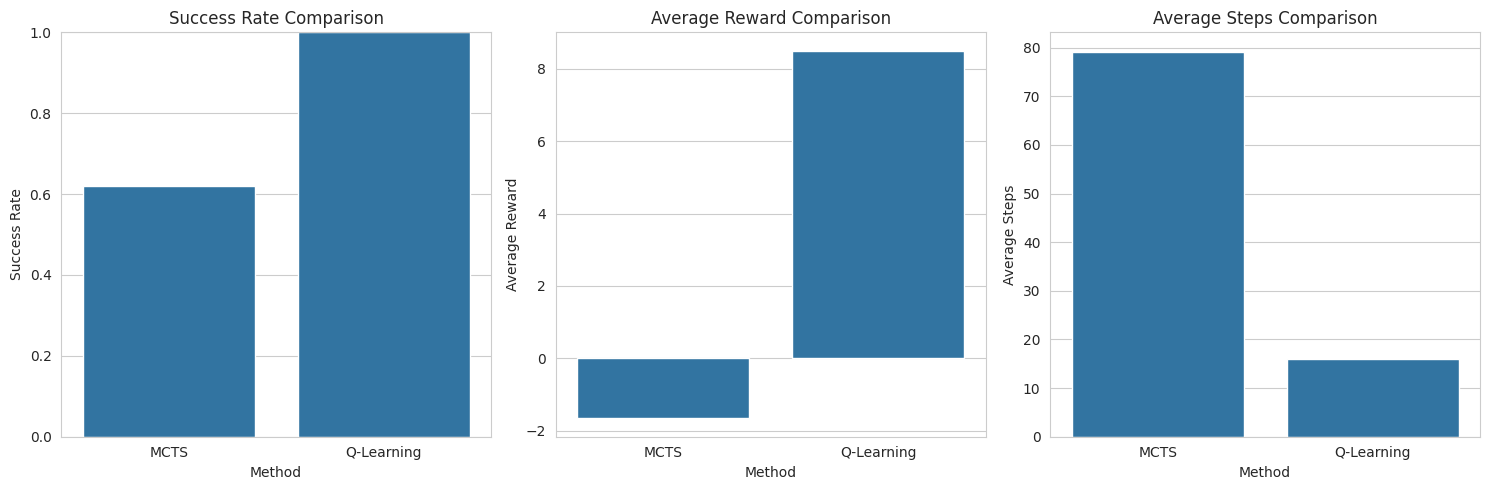

In [ ]:
# 5. Compare Performance of MCTS and Q-Learning
# ===========================================

def evaluate_agent(agent_type, env, num_episodes=100):
    """Evaluate an agent's performance"""
    success_count = 0
    total_rewards = 0
    total_steps = 0

    if agent_type == 'mcts':
        mcts = MCTS(env, exploration_weight=1.0)

        for _ in range(num_episodes):
            state, _ = env.reset()
            agent_pos = tuple(map(tuple, np.where(state == 4 if 4 in state else state == 3)))
            agent_pos = (agent_pos[0][0], agent_pos[1][0])

            done = False
            truncated = False
            episode_reward = 0
            steps = 0

            while not (done or truncated):
                action = mcts.search(agent_pos, iterations=1000)
                state, reward, done, truncated, _ = env.step(action)

                agent_pos = tuple(map(tuple, np.where(state == 4 if 4 in state else state == 3)))
                agent_pos = (agent_pos[0][0], agent_pos[1][0])

                episode_reward += reward
                steps += 1

                if steps >= 100:  # Prevent infinite loops
                    truncated = True

            if done:  # Successfully reached the goal
                success_count += 1

            total_rewards += episode_reward
            total_steps += steps

    elif agent_type == 'qlearning':
        # Use the trained Q-agent
        for _ in range(num_episodes):
            state, _ = env.reset()
            agent_pos = tuple(map(tuple, np.where(state == 4 if 4 in state else state == 3)))
            agent_pos = (agent_pos[0][0], agent_pos[1][0])

            done = False
            truncated = False
            episode_reward = 0
            steps = 0

            while not (done or truncated):
                # Use greedy policy (no exploration)
                q_values = [q_agent.get_q_value(agent_pos, a) for a in range(4)]
                action = np.argmax(q_values)

                state, reward, done, truncated, _ = env.step(action)

                agent_pos = tuple(map(tuple, np.where(state == 4 if 4 in state else state == 3)))
                agent_pos = (agent_pos[0][0], agent_pos[1][0])

                episode_reward += reward
                steps += 1

                if steps >= 100:  # Prevent infinite loops
                    truncated = True

            if done:  # Successfully reached the goal
                success_count += 1

            total_rewards += episode_reward
            total_steps += steps

    return {
        'success_rate': success_count / num_episodes,
        'avg_reward': total_rewards / num_episodes,
        'avg_steps': total_steps / num_episodes
    }

# Compare both methods
env = MazeEnv()
mcts_eval = evaluate_agent('mcts', env, num_episodes=50)
q_learning_eval = evaluate_agent('qlearning', env, num_episodes=50)

# Print results
print("MCTS Evaluation:")
print(f"Success Rate: {mcts_eval['success_rate']:.2f}")
print(f"Average Reward: {mcts_eval['avg_reward']:.2f}")
print(f"Average Steps: {mcts_eval['avg_steps']:.2f}")
print("\nQ-Learning Evaluation:")
print(f"Success Rate: {q_learning_eval['success_rate']:.2f}")
print(f"Average Reward: {q_learning_eval['avg_reward']:.2f}")
print(f"Average Steps: {q_learning_eval['avg_steps']:.2f}")

# Visualize comparison
comparison_data = pd.DataFrame({
    'Method': ['MCTS', 'Q-Learning'],
    'Success Rate': [mcts_eval['success_rate'], q_learning_eval['success_rate']],
    'Average Reward': [mcts_eval['avg_reward'], q_learning_eval['avg_reward']],
    'Average Steps': [mcts_eval['avg_steps'], q_learning_eval['avg_steps']]
})

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='Method', y='Success Rate', data=comparison_data)
plt.title('Success Rate Comparison')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
sns.barplot(x='Method', y='Average Reward', data=comparison_data)
plt.title('Average Reward Comparison')

plt.subplot(1, 3, 3)
sns.barplot(x='Method', y='Average Steps', data=comparison_data)
plt.title('Average Steps Comparison')

plt.tight_layout()
plt.savefig('method_comparison.png')
plt.show()
